In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import requests as rq

from urllib.parse import urlencode
import matplotlib.pyplot as plt
from datetime import datetime


Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
customer_data = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

download_url_customer_data = rq.get(base_url + urlencode(dict(public_key=customer_data))).json()['href']
download_response = rq.get(download_url_customer_data)
ab_tests = pd.read_csv(download_url_customer_data, sep=';')

### Посмотрим на данные

In [3]:
ab_tests.shape

(404770, 3)

In [4]:
ab_tests.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
ab_tests.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [6]:
ab_tests.duplicated().sum()

0

In [7]:
ab_tests.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

### Продуктовые метрики

Подсчитаю основные продуктовые метрики для обоих групп. Для этого выделю две группы и для каждой определю метрики:

**ARPU** - средний доход с одного пользователя (Общий доход / Количество пользователей)  

**Конверсия в платежи** (Paying Conversion Rate) - отношение числа пользователей, совершивших покупку, к общему числу пользователей в группе

**Общий доход (Total Revenue)** - сумма всех доходов от пользователей в каждой группе.

Основные метрики: 
- средний доход (ARPU)
- конверсия 

### Гипотеза для ARPU

**H0**: ```ARPU_b = ARPU_a```   
**H1:** ```ARPU_b > ARPU_a```    
**Alpha:** 0.05

размер выборок достаточно большой. Значит, я смогу применить односторонний **t-тест для проверки средних обеих групп (ARPU)**. Согласно ЦПТ, статистика может быть распределена нормально, даже если выборка не распределена нормально. 

### Гипотеза для конверсий

**H0:** ```conv_a = conv_b```  
**H1:** ```conv_a > conv_b```  
**Alpha:** 0.05

Для проверки **конверсии** я воспользуюсь **хи-квадратом** (предварительно составив таблицу сопряжённости с количеством платящих и неплатящих пользователей)

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

In [8]:
ab_tests_group_a = ab_tests.query('testgroup == "a"')
ab_tests_group_a = ab_tests_group_a.drop(columns=['testgroup'])
ab_tests_group_a.head()

,user_id,revenue
1,2,0
2,3,0
9,10,0
10,11,0
11,12,0


In [9]:
ab_tests_group_a.shape

(202103, 2)

In [10]:
ab_tests_group_b = ab_tests.query('testgroup == "b"')
ab_tests_group_b = ab_tests_group_b.drop(columns=['testgroup'])
ab_tests_group_b.head()

,user_id,revenue
0,1,0
3,4,0
4,5,0
5,6,0
6,7,0


In [11]:
ab_tests_group_b.shape

(202667, 2)

In [12]:
#A - control, B - test
paying_users_group_a = 1928
paying_users_group_b = 1805
group_a_ids = ab_tests_group_a.user_id.nunique()
group_b_ids = ab_tests_group_b.user_id.nunique()
print(group_a_ids, group_b_ids)

202103 202667


In [13]:
group_a_revenue = ab_tests_group_a.revenue.sum()
group_b_revenue = ab_tests_group_b.revenue.sum()
print(group_a_revenue)
print(group_b_revenue)
print(group_b_revenue - group_a_revenue)

5136189
5421603
285414


Доход группы B больше на 285 414

In [14]:
conv_group_a = paying_users_group_a / group_a_ids * 100
conv_group_b = paying_users_group_b / group_b_ids * 100
print(conv_group_a)
print(conv_group_b)

0.9539690157988748
0.8906235351586593


Конверсия группы А в платящего пользователя больше на 6% 


In [15]:
group_a_arpu = group_a_revenue / group_a_ids
group_b_arpu = group_b_revenue / group_b_ids

In [16]:
print(group_a_arpu)
print(group_b_arpu)

25.413719736965806
26.75128659327863


ARPU для обеих групп почти одинаков

In [17]:
group_a_arppu =  group_a_revenue / paying_users_group_a
group_b_arppu = group_b_revenue / paying_users_group_b 
print(group_a_arppu)
print(group_b_arppu)

2663.9984439834025
3003.6581717451522


ARPPU группы B существенно выше ARPPU группы А 

### Промежуточные выводы

Выборки имеют большой размер. В контрольной группе **202103** пользователя, в тестовой – **202667**. Согласно условию в контрольной группе **1928** платящих пользователей, а в тестовой – **1805**.

Конверсия контрольной группы больше на **~6%**

Доход тестовой группы больше на **285414**

**ARPU** обеих групп примерно одинаков, но **ARPPU** различается. У тестовой группы эта метрика выше. Имеет смысл исследовать платящих пользователей тестовой группы

### Посмотрим подробнее на доход пользователей

In [18]:
ab_tests.revenue.nunique()

1477

In [19]:
ab_tests.revenue.unique()

array([   0,  351, 3797, ..., 2105, 3383, 3120])

In [20]:
ab_tests.revenue.value_counts()

revenue
0       401037
310         18
206         18
224         17
265         17
         ...  
2074         1
3011         1
2407         1
3438         1
3120         1
Name: count, Length: 1477, dtype: int64

In [21]:
ab_tests.groupby('revenue', as_index=False) \
        .agg({'revenue':'count'}) \
        .sort_values(by=['revenue'], ascending=False).head()

,revenue
0,401037
111,18
7,18
198,17
66,17


Сразу видно, что в датасете встречается очень много значений ```revenue = 0```, то есть есть неплатящие пользователи

Поделю датасет по группам, чтобы посмотреть на неплатящих пользователей в группах

Также проверю распределение с помощью теста Шапиро

In [22]:
ab_tests.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


### Визуализирую распределение ```revenue``` в группе А

<Axes: xlabel='revenue', ylabel='Count'>

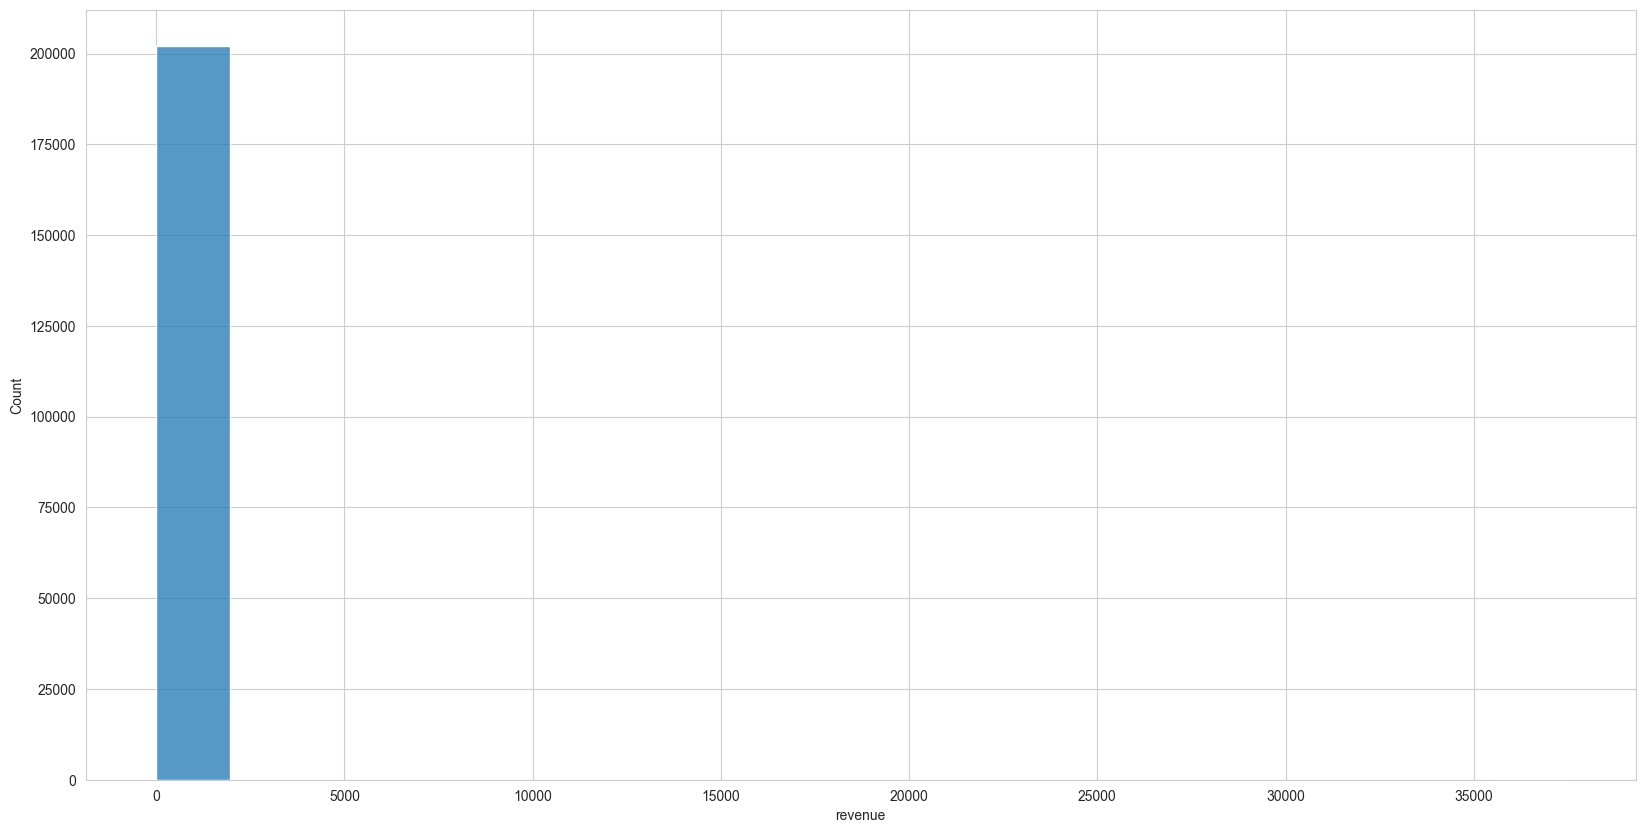

In [23]:
plt.figure(figsize=(20, 10)) 
sns.histplot(ab_tests_group_a.revenue)

Есть небольшое количество значений после отметки 35.000. Посмотрим на них внимательнее

In [24]:
paying_a_group = ab_tests.query('revenue > 0 & testgroup == "a"')[['revenue']]

<Axes: ylabel='Count'>

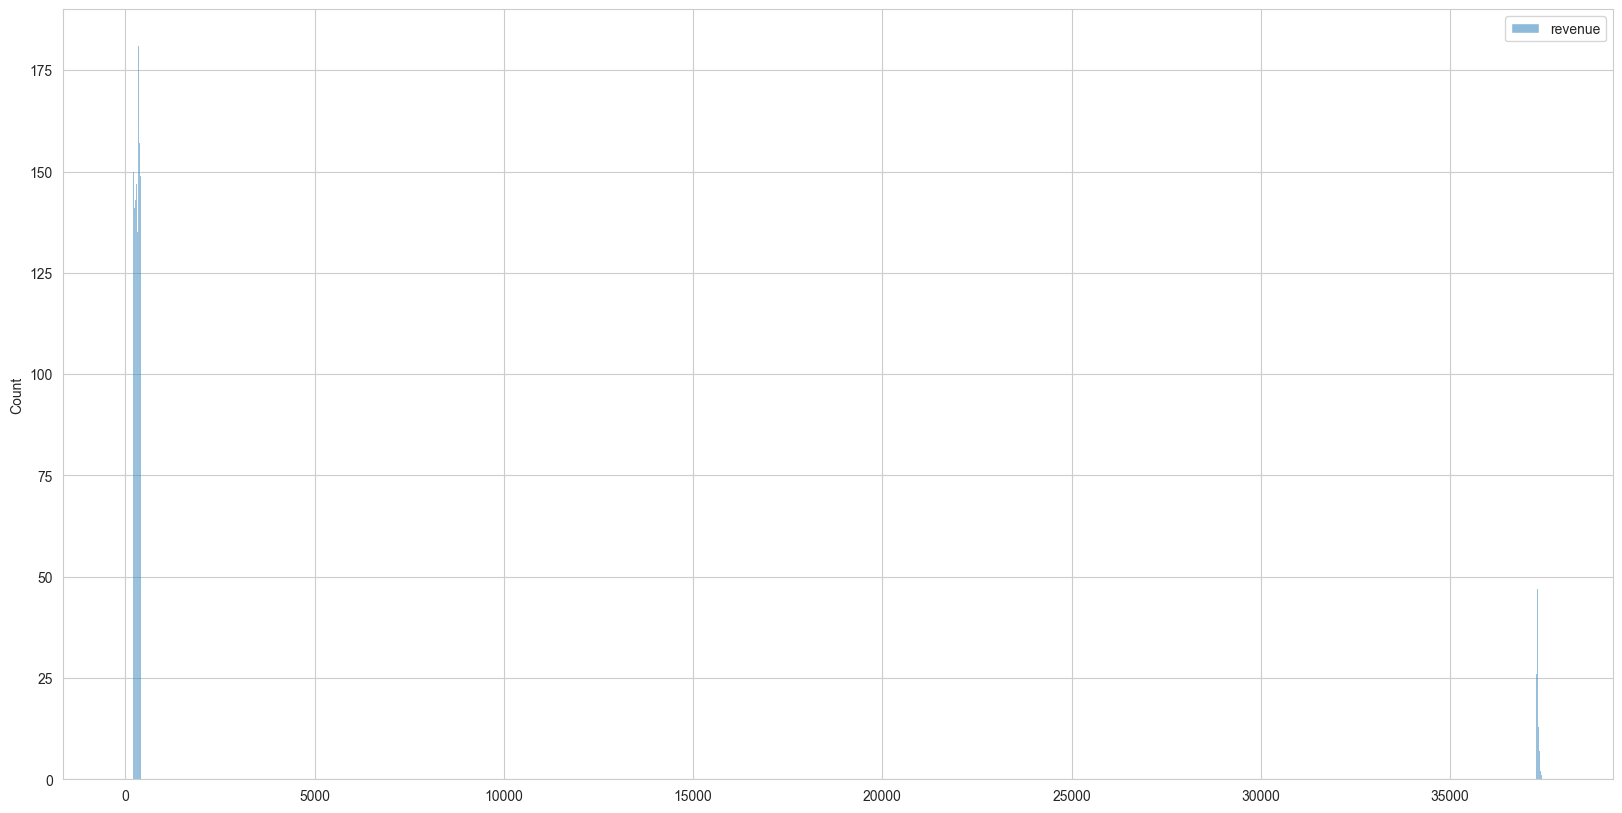

In [25]:
plt.figure(figsize=(20, 10)) 
sns.histplot(paying_a_group)

In [26]:
ab_tests_group_a.query('revenue > 35000')

,user_id,revenue
416,417,37324
4428,4429,37304
5777,5778,37315
8065,8066,37307
8743,8744,37334
...,...,...
360696,360697,37347
378668,378669,37297
389341,389342,37298
394580,394581,37302


In [27]:
ab_tests_group_a.query('revenue > 37000 & revenue < 38000')

,user_id,revenue
416,417,37324
4428,4429,37304
5777,5778,37315
8065,8066,37307
8743,8744,37334
...,...,...
360696,360697,37347
378668,378669,37297
389341,389342,37298
394580,394581,37302


<Axes: ylabel='Count'>

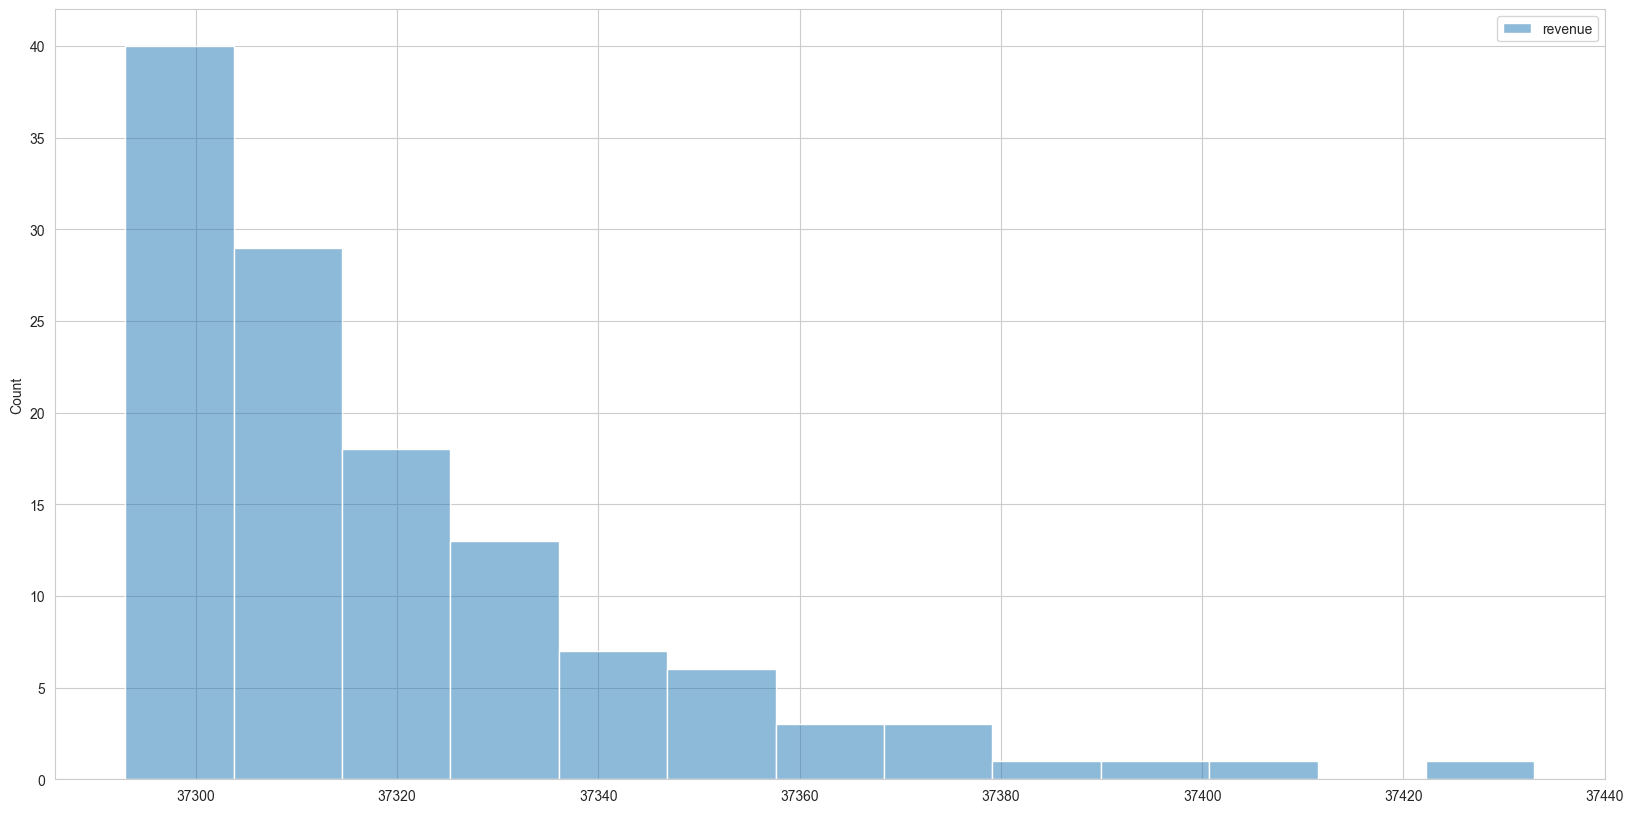

In [28]:
plt.figure(figsize=(20, 10)) 
sns.histplot(paying_a_group.query('revenue > 35000'))

In [29]:
full_revenue_a = ab_tests_group_a.revenue.sum()

In [30]:
ab_tests_group_a.query('revenue > 35000')['revenue'].sum()

4590252

In [31]:
ab_tests_group_a.query('revenue <= 35000')['revenue'].sum()

545937

In [32]:
ab_tests_group_a.query('revenue > 35000')['revenue'].sum() / full_revenue_a

0.8937077665950377

In [33]:
ab_tests_group_a.query('revenue > 35000')['user_id'].nunique()

123

In [34]:
ab_tests_group_a.query('revenue > 0 & revenue < 35000')['user_id'].nunique()

1805

In [35]:
ab_tests_group_a.query('revenue <= 35000')['revenue'].sum() / full_revenue_a

0.10629223340496231

<Axes: xlabel='revenue', ylabel='Count'>

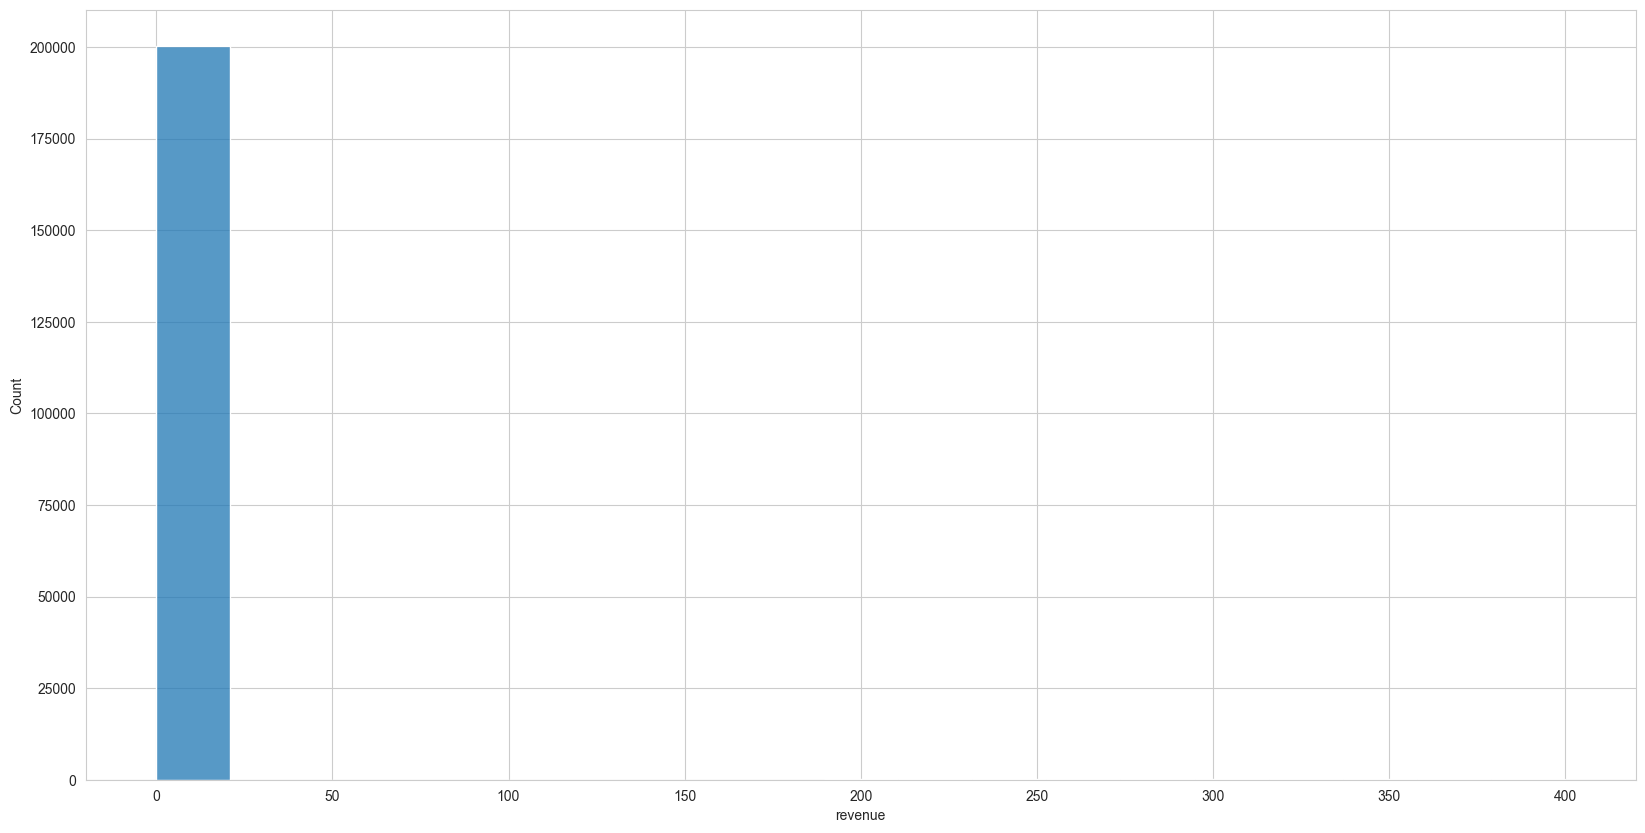

In [36]:
plt.figure(figsize=(20, 10)) 
sns.histplot(ab_tests_group_a.query('revenue <= 35000')['revenue'])

In [37]:
ab_tests_group_a.query('revenue >= 200 & revenue <= 500')['revenue'].sum()

545937

**123 пользователя** в группе А приносят намного большую прибыль (около 89%), чем все остальные пользователи. Оставшиеся пользователи (1805) делают намного меньшую выручку (около 11%)

Также можно заметить, что их ```revenue``` держится в диапазоне от 37.000 до 38.000. Можно предположить, что они покупали одинаковые товары или воспользовались одним предложением (например, купить несколько товаров со скидкой).

### Визуализирую распределение группы В

<Axes: xlabel='revenue', ylabel='Count'>

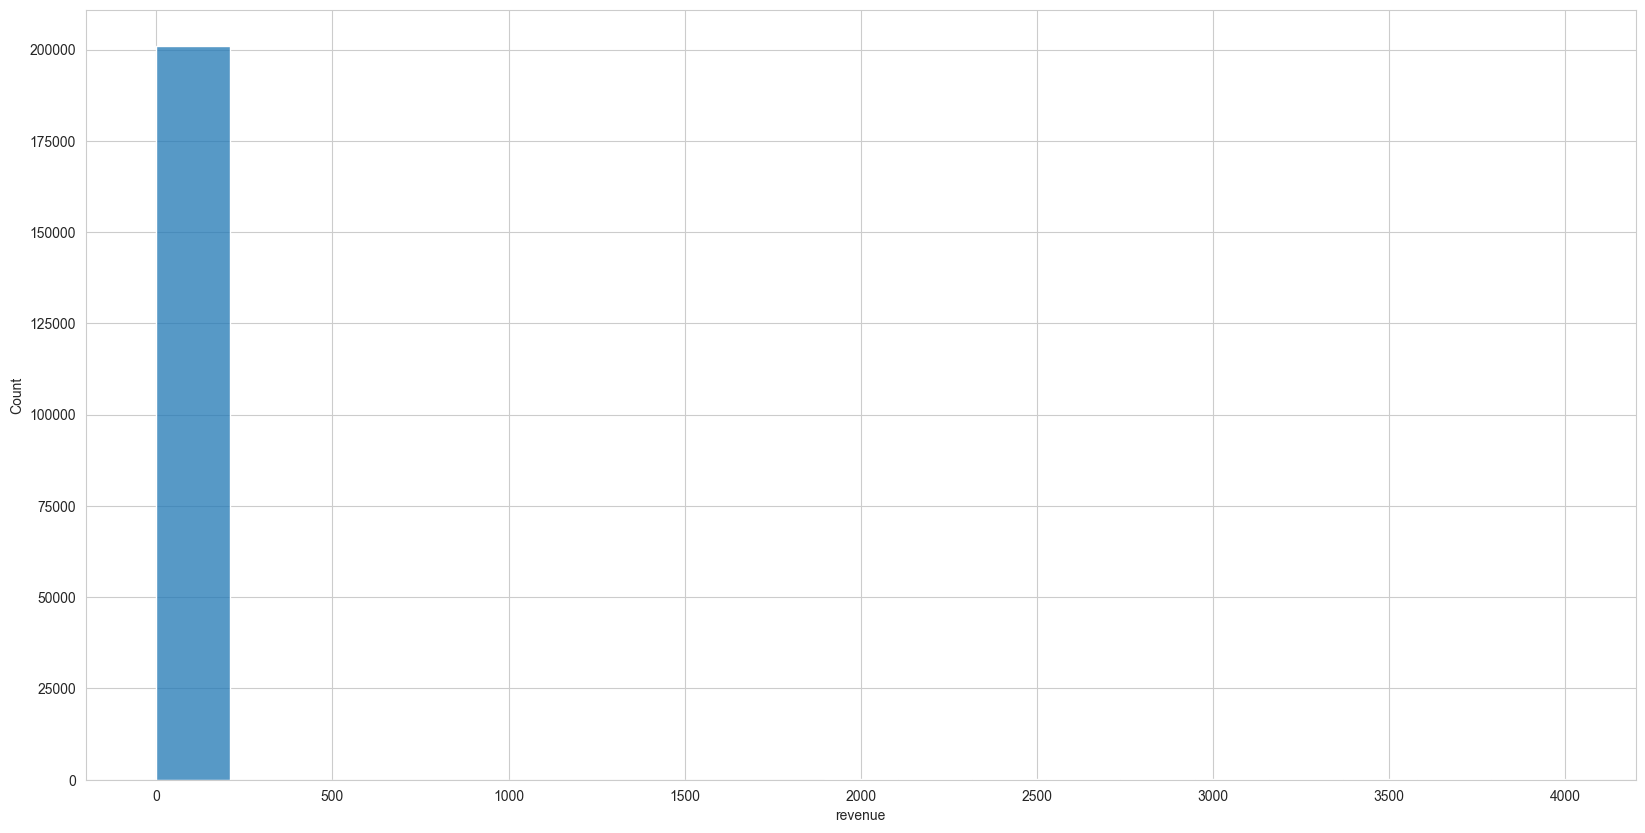

In [38]:
plt.figure(figsize=(20, 10)) 
sns.histplot(ab_tests_group_b.revenue)

Есть небольшое количество значений в промежутке между 2000 и 4000. Посмотрим на них внимательнее

In [39]:
paying_b_group = ab_tests.query('revenue > 0 & testgroup == "b"')[['revenue']]


<Axes: ylabel='Count'>

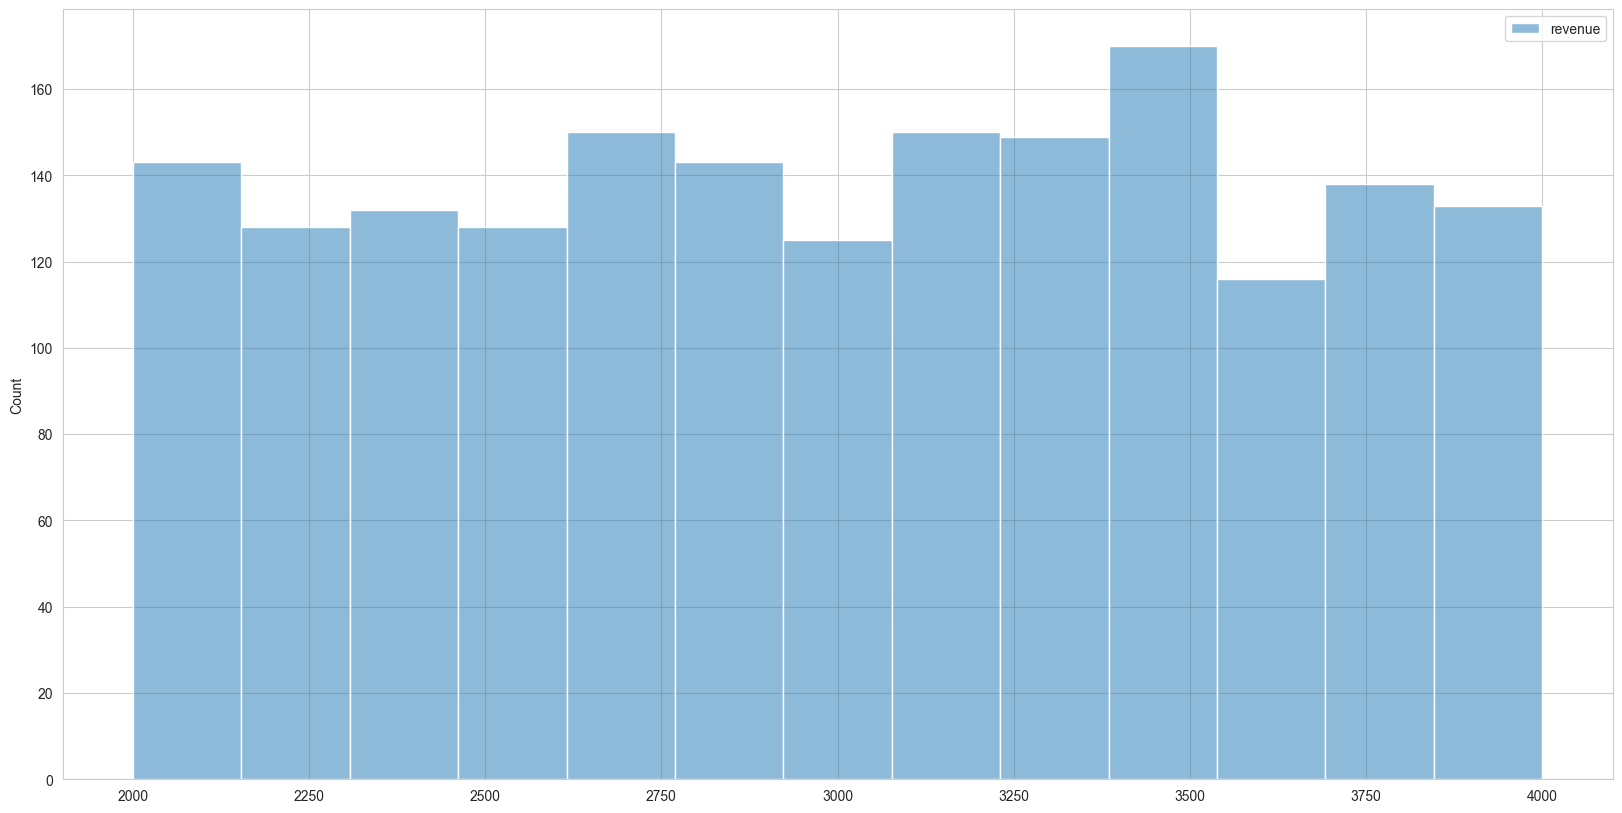

In [40]:
plt.figure(figsize=(20, 10)) 
sns.histplot(paying_b_group)

In [41]:
ab_tests_group_b.query('revenue >= 2000')['user_id'].nunique()

1805

In [42]:
full_revenue_b = ab_tests_group_b.revenue.sum()
full_revenue_b

5421603

In [43]:
ab_tests_group_b.query('revenue >= 2000')['revenue'].sum()

5421603

In [44]:
ab_tests_group_b.query('revenue >= 2000')['revenue'].sum() / full_revenue_b

1.0

In [45]:
ab_tests_group_b.query('revenue < 2000')['revenue'].sum()


0

In [46]:
ab_tests_group_b.query('revenue < 2000')['revenue'].value_counts()

revenue
0    200862
Name: count, dtype: int64

В группе В также наблюдается один сегмент платящих пользователей (их 1805). Остальные пользователи являются неплатящими (```revenue = 0```). В группе А, помимо сегмента с высоким ```revenue``` (```revenue > 35 000```) есть и другие платящие пользователи.

### Проверка распределений

Визуально видно, что распределение ненормально в обеих группах, но проверю это статистически с помощью теста Шапиро

**Нулевая гипотеза теста Шапиро (H0)**: данные распределены нормально  
**Альтернативная гипотеза теста Шапиро (H1)**: данные не распределены нормально

In [47]:
statistic, pvalue = stats.shapiro(ab_tests_group_a.revenue)
print(pvalue)
print(pvalue < 0.05)

9.154085373057082e-204
True


/Users/shvartz/Desktop/Капитал/IT strength/Karpov/analytics/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 202103.
  res = hypotest_fun_out(*samples, **kwds)


Вывод: ```pvalue``` меньше 0.05, значит отклоняем гипотезу о том, что распределение нормальное. Распределение **ненормальное**. Аналогично во второй группе

In [48]:
statistic, pvalue = stats.shapiro(ab_tests_group_b.revenue)
print(pvalue)
print(pvalue < 0.05)

1.2462736534200747e-201
True


/Users/shvartz/Desktop/Капитал/IT strength/Karpov/analytics/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 202667.
  res = hypotest_fun_out(*samples, **kwds)


### Т-тест
**H0 гипотеза Т-теста**: Средние значения двух выборок равны (различия между выборками незначимы)  
**H1 гипотеза Т-теста**: Средние значения двух выборок не равныТем не менее, из-за большого размера выборки я могу воспользоваться **T-тестом** и сравнить средние двух выборок 

In [49]:
t_stat, p_val = stats.ttest_ind(ab_tests_group_a, ab_tests_group_b)

In [50]:
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_val}")

t-статистика: [ 0.92656393 -0.62420265]
p-значение: [0.35415354 0.53249486]


In [51]:
print(p_val < 0.05)

[False False]


Я не могу отвергнуть нулевую гипотезу (нет достаточных доказательств различия средних). Можно считать **средние двух групп** (ARPU) статистически сходными. То же верно и для **ARPPU**

In [52]:
paying_a_group.shape

(1928, 1)

In [53]:
t_stat, p_val = stats.ttest_ind(paying_a_group, paying_b_group)

In [54]:
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_val}")
print(p_val < 0.05)

t-статистика: [-1.59171002]
p-значение: [0.11153459]
[False]


Проверю **конверсии** с помощью хи-квадрата

### Хи-квадрат

**H0 гипотеза хи-квадрата**: Доля платящих пользователей одинакова в обеих группах  
**H1 гипотеза хи-квадрата**: Доли платящих пользователей различаются между группами

In [55]:
ab_tests_group_a.user_id.nunique()

202103

In [56]:
a_users = ab_tests_group_a.user_id.nunique()
a_users

202103

In [57]:
non_paying_users_a = a_users - paying_users_group_a
non_paying_users_a

200175

In [58]:
b_users = ab_tests_group_b.user_id.nunique()
b_users

202667

In [59]:
non_paying_users_b = b_users - paying_users_group_b
non_paying_users_b

200862

In [60]:
contingency_table = np.array([[paying_users_group_a, non_paying_users_a], 
                               [paying_users_group_b, non_paying_users_b]])
contingency_table

array([[  1928, 200175],
       [  1805, 200862]])

In [61]:
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Статистика хи-квадрат: {chi2_stat:.4f}")
print(f"p-значение: {p_val:.4f}")
print(f"Число степеней свободы: {dof}")

Статистика хи-квадрат: 4.3747
p-значение: 0.0365
Число степеней свободы: 1


Доли платящих пользователей различаются между группами. В практическом смысле есть стат.основания утверждать, что конверсия группы А выше конверсии группы B) 

In [62]:
print(conv_group_a, conv_group_b)

0.9539690157988748 0.8906235351586593


### Выводы

- **T-тест** позволяет утверждать, что **средний доход обеих групп одинаков** (несмотря на то, что доход тестовой группы больше на **285414**
- **Хи-квадрат** позволяет утверждать, что конверсия контрольной группы **больше на 6%**, но учитывая сходство среднего дохода, разница в конверсии не привела к значимому увеличению дохода. По сути, **группа А является предпочтительной**, а оснований выкатывать новые изменения нет
- Среди платящих пользователей группы А есть 123 пользователя, которые делают б**о**льшую часть (89%) выручки. В группе также есть другие платящие пользователи, но их выручка составляет ~11%. В группе В нет такого большого разброса среди платящих пользователей. Если так произошло из-за использования особого предложения или по другим причинам, можно попробовать повторить это и провести а/б-тестирование разных предложений на других выборках пользователей
- **Группа A привлекает больше платящих клиентов, чем группа B**, при одинаковом среднем чеке. Поэтому если наша цель - максимизировать количество платящих клиентов при сохранении текущего уровня средних платежей, то **набор предложений, тестировавшийся в группе A, также можно считать лучшим**